# FrequencySeries の新機能と高度な操作

このノートブックでは、`gwexpy` で拡張された `FrequencySeries` クラスの新しいメソッドと機能について紹介します。
主に複素スペクトルの扱い、微積分、フィルタリング（スムージング）、および他ライブラリとの連携機能に焦点を当てます。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gwexpy.timeseries import TimeSeries
from gwexpy.frequencyseries import FrequencySeries
import astropy.units as u

# グラフのスタイル設定
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

## 1. データの準備

まずは `TimeSeries` から FFT を用いて `FrequencySeries` を作成します。
ここでは、特定の周波数成分を持つテスト信号を生成します。

In [2]:
fs = 1024
t = np.arange(0, 4, 1/fs)
data = np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 100 * t) + np.random.normal(scale=0.1, size=len(t))
ts = TimeSeries(data, dt=1/fs, unit='m', name='Test Signal')

# FFT を実行して FrequencySeries を取得 (transient モードを使用してパディングを適用)
spec = ts.fft(mode="transient", pad_left=1.0, pad_right=1.0, nfft_mode="next_fast_len")

print(f"Type: {type(spec)}")
print(f"Length: {len(spec)}")
print(f"df: {spec.df}")

Type: <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'>
Length: 3073
df: 0.16666666666666666 Hz


## 2. 複素スペクトルの可視化と変換

### 位相と振幅
`phase()`, `degree()`, `to_db()` メソッドを使用すると、複素スペクトルを直感的な単位に変換できます。

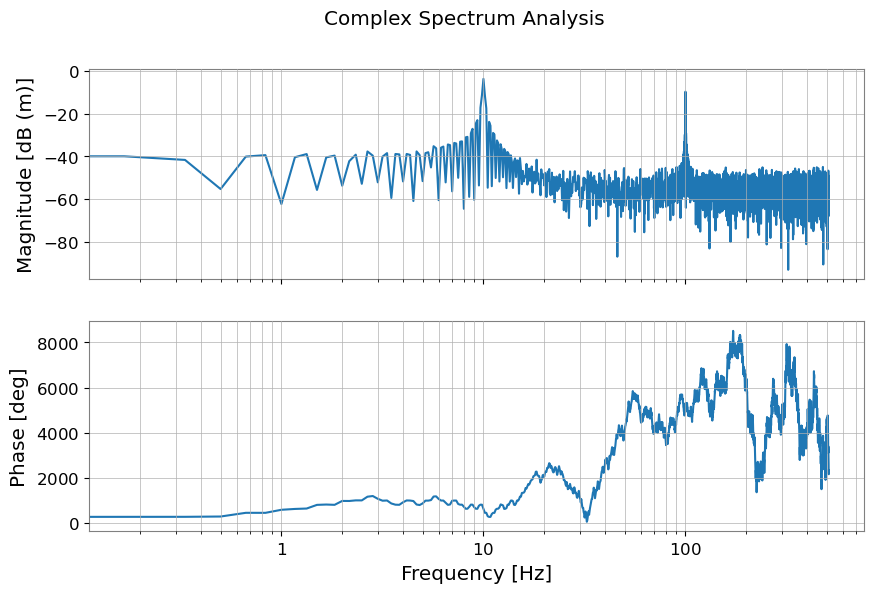

In [3]:
# 振幅を dB に変換 (ref=1.0, 20*log10)
spec_db = spec.to_db()

# 位相を取得 (度数表記、unwrap=True で連続化)
spec_phase = spec.degree(unwrap=True)

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].semilogx(spec_db.frequencies, spec_db)
ax[0].set_ylabel('Magnitude [dB (m)]')
ax[0].grid(True, which='both')

ax[1].semilogx(spec_phase.frequencies, spec_phase)
ax[1].set_ylabel('Phase [deg]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].grid(True, which='both')
plt.suptitle('Complex Spectrum Analysis')
plt.show()

## 3. 周波数ドメインでの微積分

`differentiate_time()` および `integrate_time()` メソッドにより、周波数ドメインで微分・積分を行うことができます。
これは「変位・速度・加速度」の変換（$(2 \pi i f)^n$ の乗算）を簡単に行うための機能です。

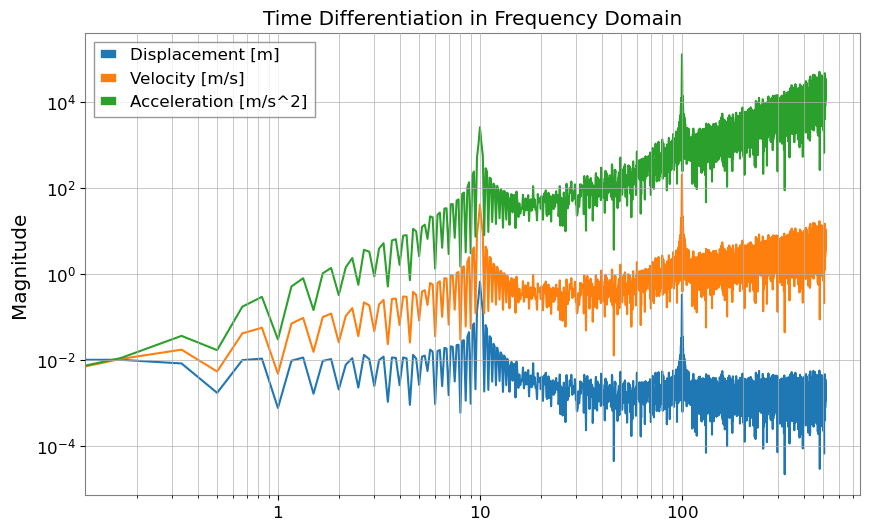

In [4]:
# 変位 (m) -> 速度 (m/s) に微分
vel_spec = spec.differentiate_time()

# 変位 (m) -> 加速度 (m/s^2) に 2回微分
accel_spec = vel_spec.differentiate_time()

plt.figure()
plt.loglog(spec.frequencies, np.abs(spec), label='Displacement [m]')
plt.loglog(vel_spec.frequencies, np.abs(vel_spec), label='Velocity [m/s]')
plt.loglog(accel_spec.frequencies, np.abs(accel_spec), label='Acceleration [m/s^2]')
plt.legend()
plt.grid(True, which='both')
plt.title('Time Differentiation in Frequency Domain')
plt.ylabel('Magnitude')
plt.show()

## 4. スペクトルのスムージングとピーク検出

### スムージング
`smooth()` メソッドを使用すると、移動平均などによるスペクトルの平滑化が可能です。

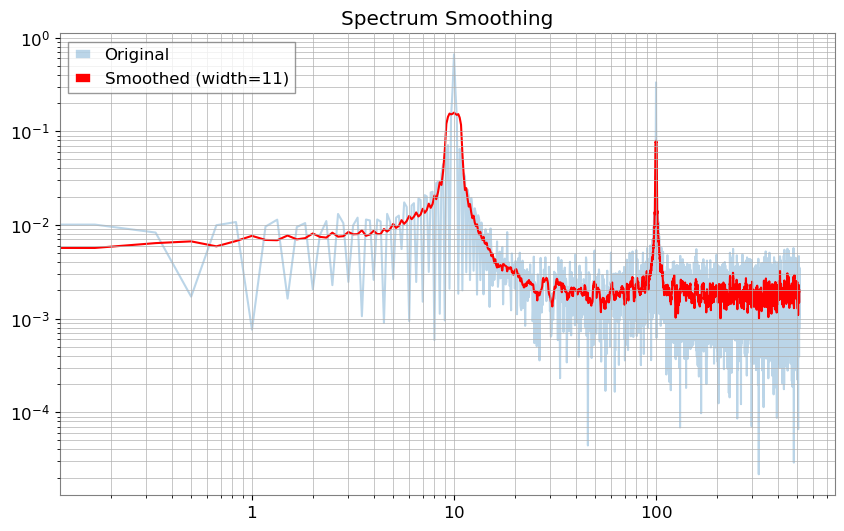

In [5]:
# 振幅ドメインで 11 サンプルのスムージング
spec_smooth = spec.smooth(width=11)

plt.figure()
plt.loglog(spec.frequencies, np.abs(spec), alpha=0.3, label='Original')
plt.loglog(spec_smooth.frequencies, np.abs(spec_smooth), color='red', label='Smoothed (width=11)')
plt.legend()
plt.grid(True, which='both')
plt.title('Spectrum Smoothing')
plt.show()

### ピーク検出
`find_peaks()` メソッドは `scipy.signal.find_peaks` をラップしており、特定の閾値を超えるピークを簡単に抽出できます。

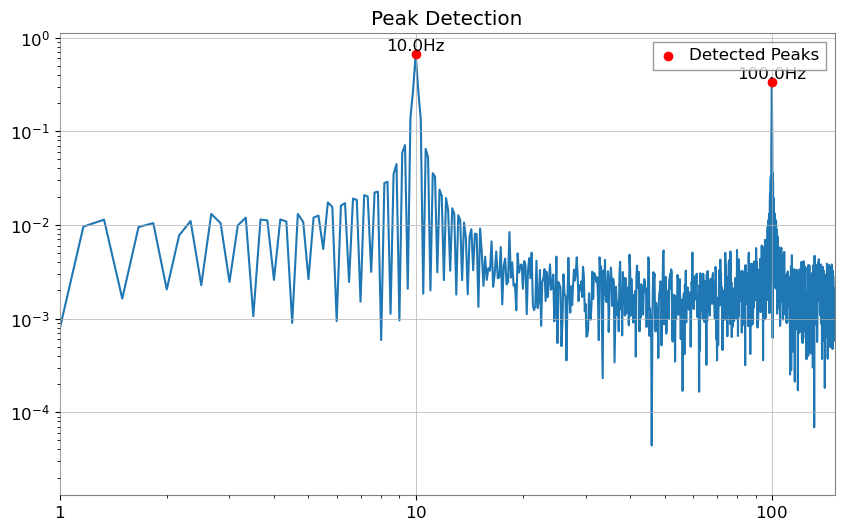

In [6]:
# 振幅 0.2 以上のピークを探す
peak_indices, props = spec.find_peaks(threshold=0.2)

peak_freqs = spec.frequencies[peak_indices]
peak_values = np.abs(spec[peak_indices])

plt.figure()
plt.plot(spec.frequencies, np.abs(spec))
plt.scatter(peak_freqs, peak_values, color='red', zorder=3, label='Detected Peaks')
for f, v in zip(peak_freqs.value, peak_values.value):
    plt.text(f, v, f"{f:.1f}Hz", ha='center', va='bottom')

plt.xlim(1, 150)
plt.xscale('log')
plt.yscale('log')
plt.title('Peak Detection')
plt.legend()
plt.show()

## 5. 高度な解析機能

### 群遅延 (Group Delay)
`group_delay()` メソッドは、位相の周波数微分から群遅延（信号のエンベロープの遅延）を計算します。

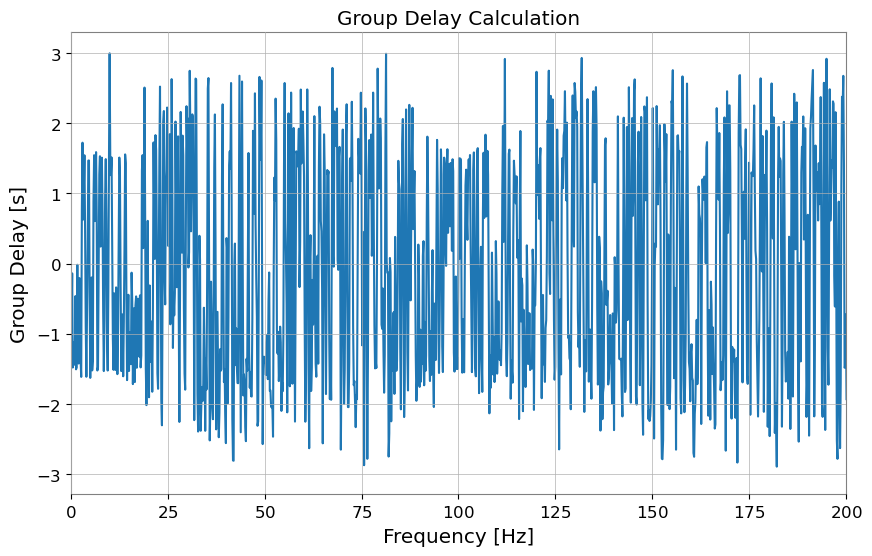

In [7]:
gd = spec.group_delay()

plt.figure()
plt.plot(gd.frequencies, gd)
plt.ylabel('Group Delay [s]')
plt.xlabel('Frequency [Hz]')
plt.xlim(0, 200)
plt.title('Group Delay Calculation')
plt.show()

### 逆FFT (ifft)
`ifft()` メソッドは、`TimeSeries` を返します。`mode="transient"` で FFT した結果であっても、情報を引き継いで元の長さに戻す (trim=True) などの制御が可能です。

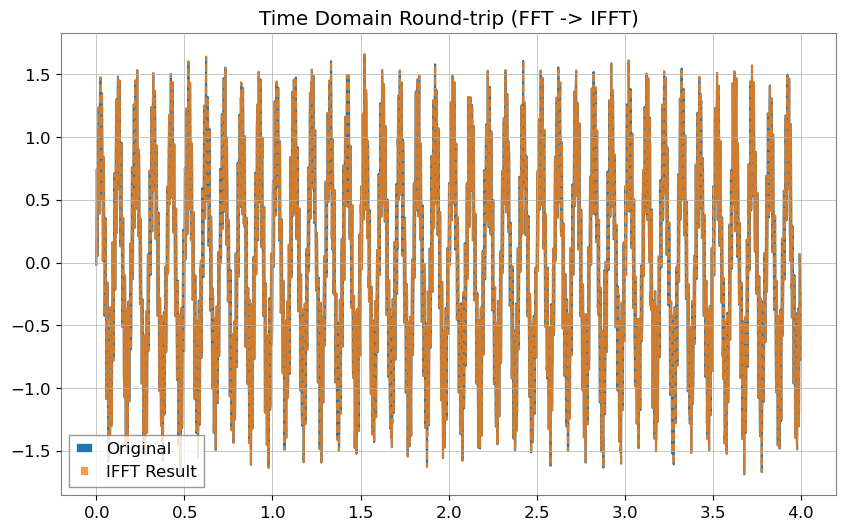

In [8]:
# 逆 FFT で TimeSeries に戻す
# mode="auto" は、入力 FrequencySeries が持つ transient 情報を読み取って適切に処理します
inv_ts = spec.ifft(mode="auto")

plt.figure()
plt.plot(ts, label='Original')
plt.plot(inv_ts, '--', label='IFFT Result', alpha=0.8)
plt.legend()
plt.title('Time Domain Round-trip (FFT -> IFFT)')
plt.show()

## 6. 他ライブラリとの連携

Pandas, xarray, control ライブラリとの相互変換が追加されています。

In [9]:
# Pandas Series へ変換
pd_series = spec.to_pandas()
print("Pandas index sample:", pd_series.index[:5])

# xarray DataArray へ変換
da = spec.to_xarray()
print("xarray coord name:", list(da.coords))

# control.FRD へ変換 (制御系の解析に使用可能)
try:
    from control import FRD
    frd_obj = spec.to_control_frd()
    print("Successfully converted to control.FRD")
except ImportError:
    print("python-control library not installed")

Pandas index sample: Index([0.0, 0.16666666666666666, 0.3333333333333333, 0.5, 0.6666666666666666], dtype='float64', name='frequency')
xarray coord name: ['frequency']
Successfully converted to control.FRD


## 7. FrequencySeriesMatrix チュートリアル

In [10]:
#%matplotlib inline
#from matplotlib_inline.backend_inline import set_matplotlib_formats
#set_matplotlib_formats("svg")
import matplotlib
matplotlib.use("module://matplotlib_inline.backend_inline", force=True)

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from IPython.display import display

import sys
from pathlib import Path

# Allow `import gwexpy` when running this notebook from `examples/`.
cwd = Path.cwd().resolve()
for p in [cwd, *cwd.parents]:
    if (p / "gwexpy").is_dir():
        p_str = str(p)
        if p_str not in sys.path:
            sys.path.insert(0, p_str)
        break

from gwexpy.frequencyseries import FrequencySeriesMatrix, FrequencySeries
from gwexpy.timeseries import TimeSeriesMatrix

np.set_printoptions(precision=4, suppress=True)
plt.rcParams.update({"figure.figsize": (5, 3), "axes.grid": True})


### 代表データを用意
`TimeSeriesMatrix` から `fft/asd` を計算して、`FrequencySeriesMatrix` を得ます。

tsm (2, 2, 1024) sample_rate 256.0 Hz
fft (2, 2, 513) df 0.25 Hz f0 0.0 Hz
asd (2, 2, 129) unit V / Hz(1/2)
frequencies[:5] [0. 1. 2. 3. 4.] Hz


<SeriesMatrix shape=(2, 2, 129) rows=('r0', 'r1') cols=('c0', 'c1')>

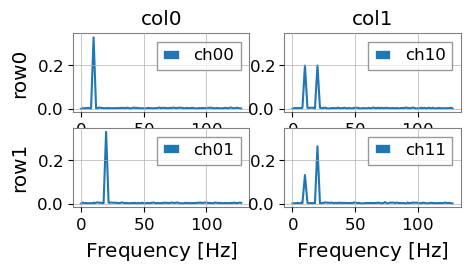

In [11]:
rng = np.random.default_rng(0)

n = 1024
dt = (1 / 256) * u.s
t0 = 0 * u.s
t = (np.arange(n) * dt).to_value(u.s)

tone10 = np.sin(2 * np.pi * 10 * t)
tone20 = np.sin(2 * np.pi * 20 * t + 0.3)

data = np.empty((2, 2, n), dtype=float)
data[0, 0] = 0.5 * tone10 + 0.05 * rng.normal(size=n)
data[0, 1] = 0.5 * tone20 + 0.05 * rng.normal(size=n)
data[1, 0] = 0.3 * tone10 + 0.3 * tone20 + 0.05 * rng.normal(size=n)
data[1, 1] = 0.2 * tone10 - 0.4 * tone20 + 0.05 * rng.normal(size=n)

units = np.full((2, 2), u.V)
names = [["ch00", "ch01"], ["ch10", "ch11"]]
channels = [["X:A", "X:B"], ["Y:A", "Y:B"]]

tsm = TimeSeriesMatrix(
    data,
    dt=dt,
    t0=t0,
    units=units,
    names=names,
    channels=channels,
    rows={"r0": {"name": "row0"}, "r1": {"name": "row1"}},
    cols={"c0": {"name": "col0"}, "c1": {"name": "col1"}},
    name="demo",
)

fft = tsm.fft()
asd = tsm.asd(fftlength=1, overlap=0.5)

print("tsm", tsm.shape, "sample_rate", tsm.sample_rate)
print("fft", fft.shape, "df", fft.df, "f0", fft.f0)
print("asd", asd.shape, "unit", asd[0, 0].unit)
print("frequencies[:5]", asd.frequencies[:5])

display(asd)
asd.plot(subplots=True);


### 多様な入力パターン（コンストラクタ例）
`df/f0`、`frequencies`、`FrequencySeries` の 2D リスト、`Quantity` 入力などを確認します。

In [12]:
print("=== FrequencySeriesMatrix コンストラクタ例 ===")

freqs = np.linspace(0, 64, 65) * u.Hz
f = freqs.to_value(u.Hz)

peak10 = np.exp(-0.5 * ((f - 10) / 1.5) ** 2)
peak20 = np.exp(-0.5 * ((f - 20) / 2.0) ** 2)

data_f = np.empty((2, 2, len(freqs)), dtype=float)
data_f[0, 0] = peak10
data_f[0, 1] = peak20
data_f[1, 0] = 0.6 * peak10 + 0.4 * peak20
data_f[1, 1] = 0.2 * peak10 - 0.5 * peak20

units_f = np.full((2, 2), u.V / u.Hz ** 0.5)
names_f = [["p10", "p20"], ["mix", "diff"]]
channels_f = [["X:A", "X:B"], ["Y:A", "Y:B"]]

# ケース 1: frequencies を明示
fsm = FrequencySeriesMatrix(
    data_f,
    frequencies=freqs,
    units=units_f,
    names=names_f,
    channels=channels_f,
    rows={"r0": {"name": "row0"}, "r1": {"name": "row1"}},
    cols={"c0": {"name": "col0"}, "c1": {"name": "col1"}},
    name="peaks",
)
print("case1 frequencies", fsm.shape, "df", fsm.df, "f0", fsm.f0)

# ケース 2: df/f0 を指定（Index.define で軸を生成）
fsm_df = FrequencySeriesMatrix(data_f, df=1 * u.Hz, f0=0 * u.Hz, units=units_f, names=names_f)
print("case2 df/f0", fsm_df.shape, "df", fsm_df.df)

# ケース 3: FrequencySeries の 2D リストから構築
fs00 = FrequencySeries(data_f[0, 0], frequencies=freqs, unit=units_f[0, 0], name="p10", channel="X:A")
fs01 = FrequencySeries(data_f[0, 1], frequencies=freqs, unit=units_f[0, 1], name="p20", channel="X:B")
fs10 = FrequencySeries(data_f[1, 0], frequencies=freqs, unit=units_f[1, 0], name="mix", channel="Y:A")
fs11 = FrequencySeries(data_f[1, 1], frequencies=freqs, unit=units_f[1, 1], name="diff", channel="Y:B")
fsm_from_fs = FrequencySeriesMatrix([[fs00, fs01], [fs10, fs11]])
print("case3 from FrequencySeries", fsm_from_fs.shape, "cell type", type(fsm_from_fs[0, 0]))

# ケース 4: Quantity 入力（units を自動設定）
fsm_q = FrequencySeriesMatrix(data_f * (u.mV / u.Hz ** 0.5), frequencies=freqs)
print("case4 Quantity meta unit", fsm_q.meta[0, 0].unit)

# ケース 5: 不規則 frequencies
irreg = np.array([0, 1, 2, 4, 8]) * u.Hz
fsm_irreg = FrequencySeriesMatrix(np.ones((1, 1, len(irreg))), frequencies=irreg, units=[[u.V]], names=[["irreg"]])
print("case5 irregular frequencies", fsm_irreg.frequencies)


=== FrequencySeriesMatrix コンストラクタ例 ===
case1 frequencies (2, 2, 65) df 1.0 Hz f0 0.0 Hz
case2 df/f0 (2, 2, 65) df 1.0 Hz
case3 from FrequencySeries (2, 2, 65) cell type <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'>
case4 Quantity meta unit mV / Hz(1/2)
case5 irregular frequencies [0. 1. 2. 4. 8.] Hz


### 参照・切り出し
- `fsm[i, j]` は `FrequencySeries` を返す
- スライスは `FrequencySeriesMatrix` を返す
- row/col ラベルでもアクセスできる

[0,0] type <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeries'> df 1.0 Hz f0 0.0 Hz unit V / Hz(1/2)
[0,0] name ch00 channel X:A
[r0,c1] name ch01 channel X:B
asd[:,0] -> <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeriesMatrix'> (2, 1, 129)


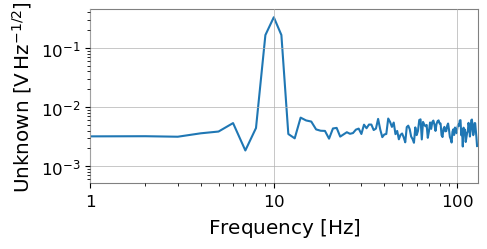

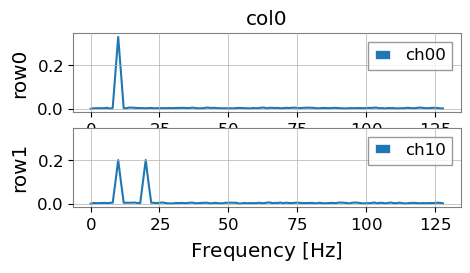

In [13]:
s00 = asd[0, 0]
print("[0,0]", "type", type(s00), "df", s00.df, "f0", s00.f0, "unit", s00.unit)
print("[0,0]", "name", s00.name, "channel", s00.channel)
s00.plot();

s01 = asd["r0", "c1"]
print("[r0,c1]", "name", s01.name, "channel", s01.channel)

sub = asd[:, 0]
print("asd[:,0] ->", type(sub), sub.shape)
sub.plot(subplots=True);


### サンプル軸編集（frequency axis）
- `diff` / `pad` は `FrequencySeriesMatrix` を返す
- `crop` は現在 `SeriesMatrix` を返すので、`view(FrequencySeriesMatrix)` で戻します（中身は同じ）

band <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeriesMatrix'> (2, 2, 35) span (<Quantity 5. Hz>, <Quantity 40. Hz>)
diffed <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeriesMatrix'> (2, 2, 34) df 1.0 Hz
padded <class 'gwexpy.frequencyseries.frequencyseries.FrequencySeriesMatrix'> (2, 2, 45) f0 0.0 Hz


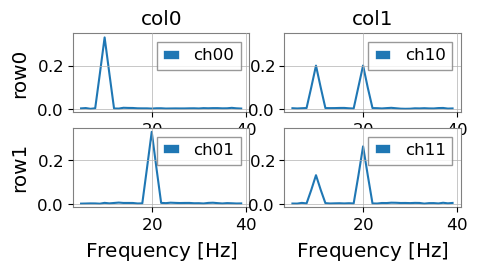

In [14]:
band = asd.crop(start=5 * u.Hz, end=40 * u.Hz).view(FrequencySeriesMatrix)
print("band", type(band), band.shape, "span", band.xspan)
band.plot(subplots=True);

diffed = band.diff(n=1)
print("diffed", type(diffed), diffed.shape, "df", diffed.df)

padded = band.pad(5)
print("padded", type(padded), padded.shape, "f0", padded.f0)


### 演算（ufunc / apply_response）
- 係数倍などの ufunc では unit が保たれる
- `apply_response` は複素/実の周波数応答（dimensionless）を掛け合わせる拡張メソッド

scaled unit V / Hz(1/2)
apply_response (2, 2, 35) dtype float64 unit V / Hz(1/2)


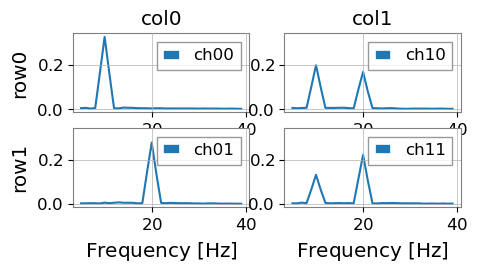

In [15]:
scaled = 2 * band
print("scaled unit", scaled[0, 0].unit)

# 30 Hz あたりから抑える単純な実応答
resp_mag = 1 / (1 + (band.frequencies / (30 * u.Hz)) ** 4)
shaped = band.apply_response(resp_mag)
print("apply_response", shaped.shape, "dtype", shaped.value.dtype, "unit", shaped[0, 0].unit)

shaped.plot(subplots=True);


### filter（magnitude-only）
`filter` は GWpy の `fdfilter` に委譲し、フィルタの「振幅応答（magnitude）」を適用します（位相は適用しません）。

ここでは例として、`scipy.signal.butter` で作った IIR フィルタを `fft` に適用してから `ifft()` で時間領域に戻します。

fft_filt (2, 2, 513) df 0.25 Hz
tsm_filt (2, 2, 1024) dt 0.00390625 s


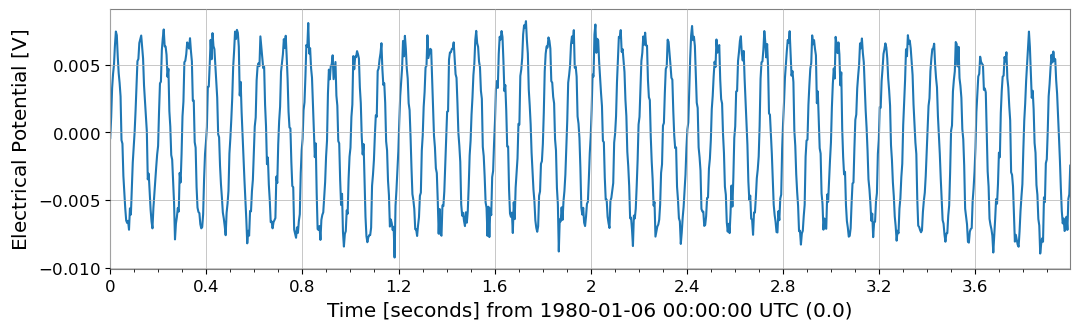

In [16]:
from scipy import signal

sr = tsm.sample_rate.to_value(u.Hz)
b, a = signal.butter(4, [5, 40], btype="bandpass", fs=sr)

fft_filt = fft.filter(b, a, analog=False)
tsm_filt = fft_filt.ifft()

print("fft_filt", fft_filt.shape, "df", fft_filt.df)
print("tsm_filt", tsm_filt.shape, "dt", tsm_filt.dt)

tsm_filt[0, 0].plot(xscale="seconds");


### ifft（FFT から時間領域へ）
`TimeSeriesMatrix.fft()` の出力に対して `ifft()` を適用すると、元の `TimeSeriesMatrix` が再現されます（数値誤差の範囲）。

ifft back (2, 2, 1024) dt 0.00390625 s t0 0.0 s
rms error (cell 0,0) 8.215025062825099e-17


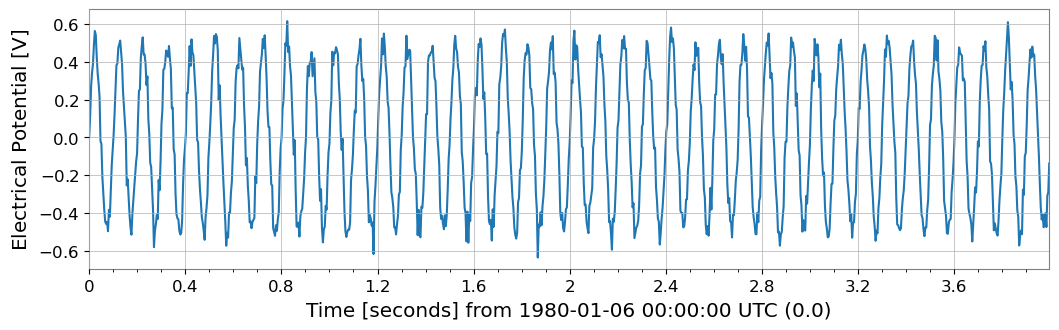

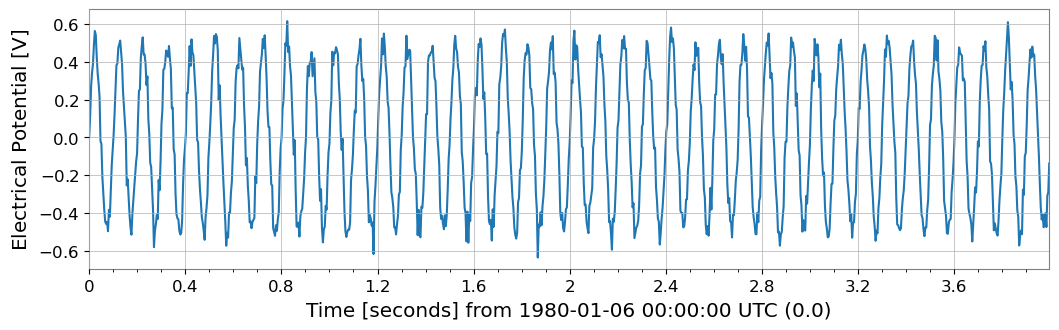

In [17]:
tsm_back = fft.ifft()
rms = np.sqrt(np.mean((tsm_back[0, 0].value - tsm[0, 0].value) ** 2))
print("ifft back", tsm_back.shape, "dt", tsm_back.dt, "t0", tsm_back.t0)
print("rms error (cell 0,0)", rms)

tsm[0, 0].plot(xscale="seconds");
tsm_back[0, 0].plot(xscale="seconds");


### 表示系: repr / plot / step
- `repr`: テキスト表示
- `_repr_html_`: ノートブックでは `display(fsm)` で表形式
- `plot` / `step`: クラスメソッドで直接描画（保存はしない）

repr:
 SeriesMatrix(shape=(2, 2, 35),  name='demo')
  epoch   : 0.0
  x0      : 5.0 Hz
  dx      : 1.0 Hz
  xunit   : Hz
  samples : 35

[ Row metadata ]
     name channel unit
key                   
r0   row0             
r1   row1             

[ Column metadata ]
     name channel unit
key                   
c0   col0             
c1   col1             

[ Elements metadata ]
          unit  name channel  row  col
0  V / Hz(1/2)  ch00     X:A    0    0
1  V / Hz(1/2)  ch01     X:B    0    1
2  V / Hz(1/2)  ch10     Y:A    1    0
3  V / Hz(1/2)  ch11     Y:B    1    1


<SeriesMatrix shape=(2, 2, 35) rows=('r0', 'r1') cols=('c0', 'c1')>

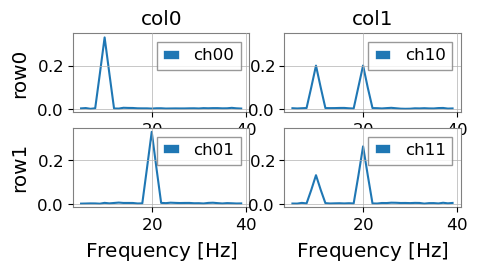

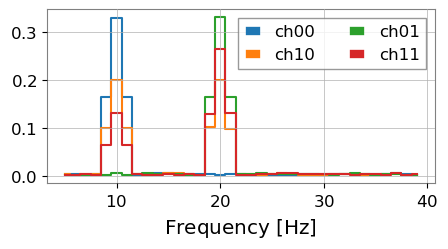

In [18]:
print("repr:\n", band)
display(band)

band.plot(subplots=True);
band.step(where="mid");


## 8. 位相と群遅延の解析 (Phase & Group Delay)

`FrequencySeries` クラスには、位相 (`phase`, `angle`) や群遅延 (`group_delay`) を計算する便利なメソッドが追加されています。

In [19]:
# 単一チャンネルを取り出す
fs = fsm[0, 0]

# 位相の計算 (ラジアン)
phi = fs.phase(unwrap=True)
print("\nUnwrapped Phase (rad) at 10Hz:", phi.value[10])

# 位相の計算 (度)
deg = fs.degree(unwrap=True)
print("Unwrapped Phase (deg) at 10Hz:", deg.value[10])

# 群遅延 (Group Delay) の計算
# Group Delay = -d(phi)/d(omega)
gd = fs.group_delay()
print("\nGroup Delay (s) at 10Hz:", gd.value[10])


Unwrapped Phase (rad) at 10Hz: 0.0
Unwrapped Phase (deg) at 10Hz: 0.0

Group Delay (s) at 10Hz: -0.0


## 9. Python Control Library との連携

制御工学の分野で標準的な `control` ライブラリの **Frequency Response Data (FRD)** オブジェクトと相互変換が可能です。
これにより、GWExPyで計測した伝達関数を、制御系の設計や解析に直接利用できます。


--- Converted to Control FRD ---
<FrequencyResponseData>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']

Freq [rad/s]  Response
------------  ---------------------
       0.000   2.234e-10        +0j
       6.283   1.523e-08        +0j
      12.566   6.658e-07        +0j
      18.850   1.866e-05        +0j
      25.133   0.0003355        +0j
      31.416    0.003866        +0j
      37.699     0.02857        +0j
      43.982      0.1353        +0j
      50.265      0.4111        +0j
      56.549      0.8007        +0j
      62.832           1        +0j
      69.115      0.8007        +0j
      75.398      0.4111        +0j
      81.681      0.1353        +0j
      87.965     0.02857        +0j
      94.248    0.003866        +0j
     100.531   0.0003355        +0j
     106.814   1.866e-05        +0j
     113.097   6.658e-07        +0j
     119.381   1.523e-08        +0j
     125.664   2.234e-10        +0j
     131.947     2.1e-12        +0j
     138.230   1.266e-14        +0j
   

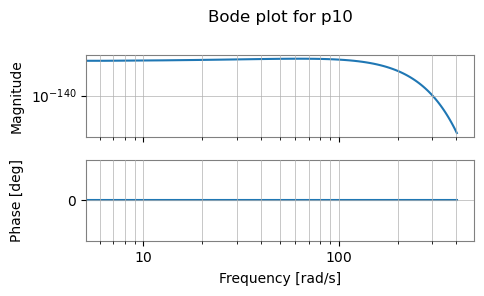

In [20]:
try:
    import control
    
    # FrequencySeries -> control.FRD 変換
    # frequency_unit="Hz" を指定すると、内部で rad/s に適切に変換して渡します
    frd_sys = fs.to_control_frd(frequency_unit="Hz")
    
    print("\n--- Converted to Control FRD ---")
    print(frd_sys)
    
    # ボード線図のプロット (controlライブラリの機能)
    control.bode(frd_sys) # (プロット環境があれば実行可能)
    
    # control.FRD -> FrequencySeries 復元
    fs_restored = FrequencySeries.from_control_frd(frd_sys, frequency_unit="Hz")
    
    print("\n--- Restored FrequencySeries ---")
    print(fs_restored)
    
except ImportError:
    print("Python Control Systems Library is not installed.")

## 10. 行列演算によるスペクトル解析

`FrequencySeriesMatrix` は行列演算をサポートしているため、チャンネル間での演算も容易です。

In [21]:
# 例: 全チャンネルの振幅スペクトル（絶対値）を計算
amp_matrix = np.abs(fsm.value)
print("\nAmplitude Matrix mean:", amp_matrix.mean())


Amplitude Matrix mean: 0.06260661332911946


## 11. 求積和 (Quadrature Sum)

直交位相の和を計算する機能です。

Noise A: 1.0, Noise B: 2.0
Total (Sqrt Sum): 2.23606797749979


/home/washimi/mambaforge/lib/python3.10/site-packages/gwpy/plot/plot.py:296: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


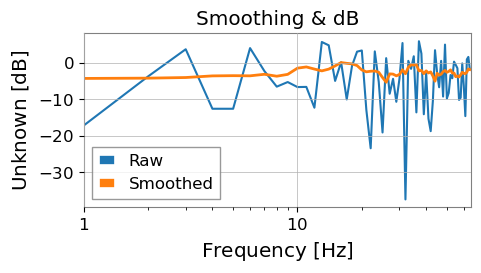

In [22]:
# Generate noisy data
np.random.seed(42)
noise = np.abs(np.random.randn(len(f)))
peak = 10.0 * np.exp(-(f - 200)**2 / 50.0)
data = noise + peak

raw = FrequencySeries(data, frequencies=f, unit='V', name='Raw Data')

# Smooth
smoothed = raw.smooth(width=10, method='amplitude')
smoothed.name = 'Smoothed'

# Convert to dB
raw_db = raw.to_db()
smoothed_db = smoothed.to_db()
raw_db.name = 'Raw (dB)'
smoothed_db.name = 'Smoothed (dB)'

plot = raw_db.plot(label='Raw', title="Smoothing & dB")
ax = plot.gca()
ax.plot(smoothed_db.frequencies, smoothed_db.value, label='Smoothed', linewidth=2)
ax.legend()
plot.show()

# Quadrature Sum (Noise Budget example)
noise_a = FrequencySeries(np.ones_like(f), frequencies=f, unit='V', name='Noise A')
noise_b = FrequencySeries(np.ones_like(f) * 2, frequencies=f, unit='V', name='Noise B')

total = noise_a.quadrature_sum(noise_b)
print(f"Noise A: {noise_a.value[0]}, Noise B: {noise_b.value[0]}")
print(f"Total (Sqrt Sum): {total.value[0]}")